## Merge OD and County data

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gp
import fiona
import shapely.geometry as geom

from pathlib import Path
import timeit
from IPython.display import clear_output
from pyproj import Geod
import numpy as np

#### Function - Convert decimal time to minutes and seconds

In [2]:
def get_time(timer):
    minutes, seconds = int(np.floor(timer)), round(np.asscalar(timer % 1)*60)
    return[minutes,  seconds]

In [3]:
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
  return dist

In [4]:
def chunk_preprocessing(df):
    # create the tract geoid columns for work and residence
    df['county_w_geoid'] = df.w_geocode.str[:11]
    df['county_h_geoid'] = df.h_geocode.str[:11]
    # create a group of all workplace geoids
    df_group = df.groupby(['county_w_geoid']).sum()
    # include only the records with over 5000 employees in the tract
    df_group = df_group[(df_group['S000'] > 50000)]
    # create list of all tracts with > 50000 workers
    top_county_list = df_group.index.tolist()
    # create a dataframe with only county with > 50000 workers
    df2 = df[df['county_w_geoid'].isin(top_county_list)]
    # sort the dataframe
    df2_sort= df2.sort_values(['county_w_geoid','county_h_geoid'], ascending=[True, True])
    # reorder df2_sort dataframe
    df2_sort = df2_sort.reset_index(drop=True)
    # drop the columns containing the geoid for blocks
    df2_sort.drop(['w_geocode','h_geocode'], axis=1, inplace=True)
    # reorder the columns of the dataframe
    cols = df2_sort.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df2_sort = df2_sort[cols ]
    # group the dataframe by the worker and home tract geoid
    df2_group = df2_sort.groupby(['county_w_geoid','county_h_geoid']).sum().reset_index()
    # load the centroid file
    centroids = pd.read_csv(county_file, dtype={'county_geoid': 'object', 'lat': 'float', 'lon': 'float'})
    # merge the centroid data frame with the grouped dataframe
    merge_result = pd.merge(df2_group, centroids,left_on=  ['county_w_geoid'],right_on= ['county_geoid'],how = 'left')
    merge_result.drop(['county_geoid'], axis=1, inplace=True)
    merge_result.rename(columns={'lat': 'w_lat', 'lon': 'w_lon'}, inplace=True)
    # merge the centroid data frame on the Fayette county h_geocode column
    merge_result = pd.merge(merge_result, centroids,left_on=  ['county_h_geoid'],right_on= ['county_geoid'],how = 'left')
    merge_result.drop(['county_geoid'], axis=1, inplace=True)
    merge_result.rename(columns={'lat': 'h_lat', 'lon': 'h_lon'}, inplace=True)
    merge_result['distance'] = Distance(merge_result['w_lat'].tolist(),merge_result['w_lon'].tolist(),merge_result['h_lat'].tolist(),merge_result['h_lon'].tolist())
    merge_result['distance'] = merge_result['distance'].apply(lambda x: round(x, decimals))
    merge_limited = merge_result[(merge_result['distance'] < 160000) & (merge_result['distance'] > 15000)]
    merge_limited['geometry'] = merge_limited.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)
    return merge_limited

In [5]:
ODpath = Path("../data/OD/")
OD_file = ODpath.joinpath("OD.csv.gz")
if OD_file.exists ():
    print ("File exist")
else:
    print ("File does not exist")
OD_out_file = ODpath.joinpath('OD_mod.csv')
countyPath = Path("../data/county/")
county_file = countyPath.joinpath("county_centroid.csv")
if county_file.exists ():
    print ("File exist")
else:
    print ("File does not exist")
county_out_file = countyPath.joinpath('tract_mod.csv')

File exist
File exist


#### Read the Origin Destination (OD) data into chunk dataframes

In [6]:
%time df_chunk = pd.read_csv(OD_file, compression='gzip', dtype={'w_geocode': str,'h_geocode':str}, chunksize=10000000)

Wall time: 5.01 ms


In [7]:
chunk_list = []

In [8]:
wgs84_geod = Geod(ellps='WGS84') 
#Distance will be measured on this ellipsoid - more accurate than a spherical method

In [9]:
chunk_num = 1
decimals = 0   

print('Reading in the chunk dataframe')
start = timeit.default_timer()
for df in df_chunk:
    print('Starting processing for chunk #', chunk_num)
    # call function to group and filter the data 
    filter_chunk = chunk_preprocessing(df)
    # append the filtered data to list
    chunk_list.append(filter_chunk)
    
    # get the current time on timer
    stop = timeit.default_timer()
    timer = np.array([(stop-start)/60])
    min_sec = get_time(timer)
    minutes, seconds = min_sec[0], min_sec[1]
    
    clear_output(wait=True)
    print('Chunk number:', chunk_num)
    print('Length of dataframe:',"{:,}".format(len(filter_chunk)),'\n')
    print('Timer:', minutes, 'minutes', seconds, 'seconds')
    chunk_num += 1

print('\nData merge complete.')

Reading in the chunk dataframe
Starting processing for chunk # 1


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
# concat the list into dataframe 
%time df_concat = pd.concat(chunk_list)

In [ ]:
len(df_concat)

In [ ]:
df_concat.head()

#### Name zip file

In [14]:
outputZip = 'od_lines.csv.gz'

#### Create full path with zip file

In [15]:
out_Zip = ODpath.joinpath(outputZip)

In [16]:
# start a timer
start = timeit.default_timer()
print ('Compressing dataframe. Please be patient.')
df_concat.to_csv(out_Zip, compression='gzip', index=None)
clear_output(wait=True)
# get the current time on timer
stop = timeit.default_timer()
timer = np.array([(stop-start)/60])
min_sec = get_time(timer)
minutes, seconds = min_sec[0], min_sec[1]
print('\nData compression complete.\nTotal time:', minutes, 'minutes', seconds, 'seconds')


Data compression complete.
Total time: 0 minutes 44 seconds


In [17]:
gdf = gp.GeoDataFrame(df_concat, geometry='geometry')

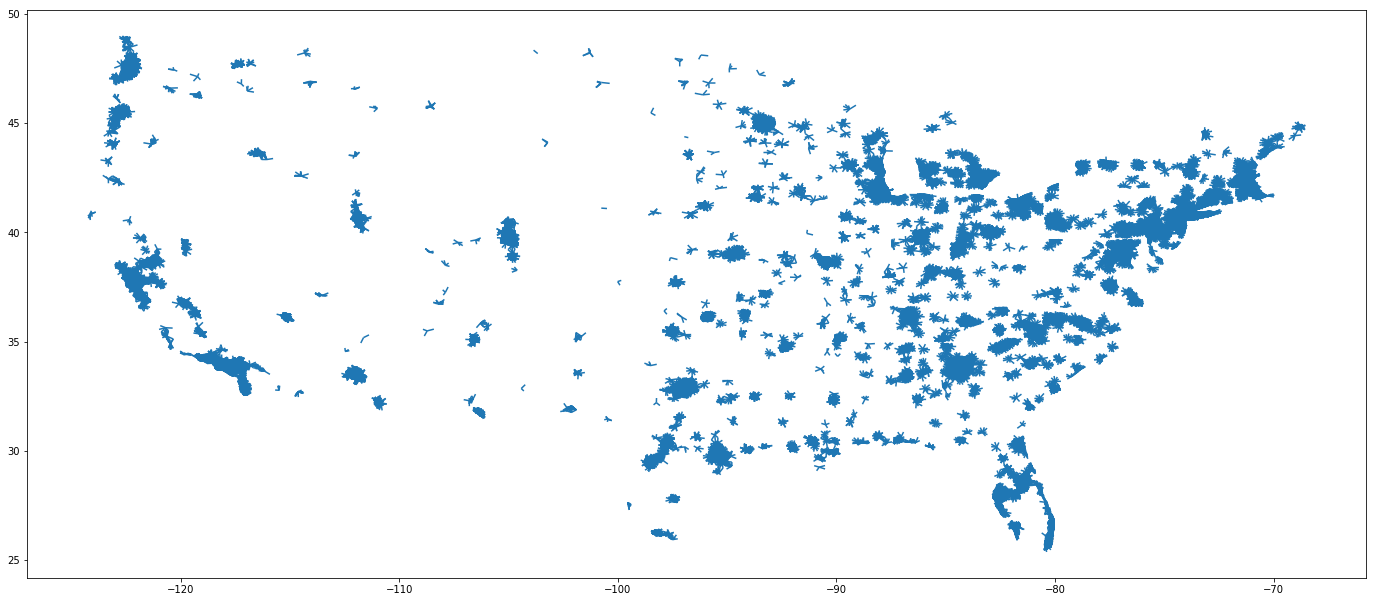

In [18]:
ax =gdf.plot(figsize=(24,24));

In [19]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 908565 entries, 20 to 352327
Data columns (total 18 columns):
tract_w_geoid    908565 non-null object
tract_h_geoid    908565 non-null object
S000             908565 non-null int64
SA01             908565 non-null int64
SA02             908565 non-null int64
SA03             908565 non-null int64
SE01             908565 non-null int64
SE02             908565 non-null int64
SE03             908565 non-null int64
SI01             908565 non-null int64
SI02             908565 non-null int64
SI03             908565 non-null int64
w_lat            908565 non-null float64
w_lon            908565 non-null float64
h_lat            908565 non-null float64
h_lon            908565 non-null float64
distance         908565 non-null float64
geometry         908565 non-null object
dtypes: float64(5), int64(10), object(3)
memory usage: 131.7+ MB


In [39]:
gdf.drop(['w_lat', 'w_lon', 'h_lat', 'h_lon'], axis=1, inplace=True)

#### Write file to GeoJSON

In [20]:
gdf.to_file("output_x.json", driver="GeoJSON")

C:\Users\mdcr226\AppData\Local\Continuum\anaconda3\envs\sandbox\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
